In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Reshape, GlobalAveragePooling1D, MultiHeadAttention
from loader import SingleFileExtractor, FolderExtractor, Segment  # <- Zde musí být tvůj loader
from tensorflow.keras.utils import Sequence

HDF_PATH = '/content/drive/MyDrive/data'
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 8
EPOCHS = 5
MODEL_DIR = "models"
MAX_SAMPLES = 3600
os.makedirs(MODEL_DIR, exist_ok=True)

class CreathonSegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []
        self.data_mean = None
        self.data_std = None

        all_data = np.concatenate([seg.data for seg in segments if seg.data is not None and len(seg.data) >= window_size])
        self.data_mean = np.nanmean(all_data)
        self.data_std = np.nanstd(all_data) + 1e-8

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - self.data_mean) / self.data_std
            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good

    limited_segments = []
    total_samples = 0
    for seg in segments:
        if seg.data is None:
            continue
        if total_samples >= MAX_SAMPLES:
            break
        seg_length = len(seg.data)
        if total_samples + seg_length > MAX_SAMPLES:
            seg.data = seg.data[:MAX_SAMPLES - total_samples]
        limited_segments.append(seg)
        total_samples += len(seg.data)

    extractor.load_data(limited_segments)
    return CreathonSegmentSequence(limited_segments, window_size, batch_size)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.pos_encoding = self.get_positional_encoding(sequence_length, d_model)

    def get_positional_encoding(self, seq_len, d_model):
        angle_rads = np.arange(seq_len)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
        pos_encoding = np.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(pos_encoding[np.newaxis], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.drop1 = Dropout(dropout_rate)
        self.drop2 = Dropout(dropout_rate)

    def call(self, x):
        attn = self.att(x, x)
        x = self.norm1(x + self.drop1(attn))
        ffn = self.ffn(x)
        return self.norm2(x + self.drop2(ffn))

def build_transformer_autoencoder(window_size, latent_dim, d_model=64, num_heads=4, dff=128, num_layers=2):
    inputs = Input(shape=(window_size, 1))
    x = Dense(d_model)(inputs)
    x = PositionalEncoding(window_size, d_model)(x)
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff)(x)
    latent = GlobalAveragePooling1D()(x)
    x = Dense(window_size * d_model)(latent)
    x = Reshape((window_size, d_model))(x)
    x = PositionalEncoding(window_size, d_model)(x)
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs, name="transformer_autoencoder")

all_files = get_file_paths(HDF_PATH)
sequence = load_sequence_from_single_file(
    file_path=all_files[0],
    annotations_path=HDF_PATH,
    signal_name=SIGNAL_NAME,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    use_anomalous=False
)

autoencoder = build_transformer_autoencoder(WINDOW_SIZE, LATENT_DIM)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
autoencoder.fit(sequence, epochs=EPOCHS)

autoencoder.save(os.path.join(MODEL_DIR, "transformer_autoencoder.keras"))

X, _ = sequence[0]
recon = autoencoder.predict(X)
X = X * sequence.data_std + sequence.data_mean
recon = recon * sequence.data_std + sequence.data_mean

plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(3, 2, i * 2 + 1)
    plt.plot(X[i].squeeze(), label="Original")
    plt.legend()
    plt.subplot(3, 2, i * 2 + 2)
    plt.plot(recon[i].squeeze(), label="Reconstruction")
    plt.legend()
plt.tight_layout()
plt.show()

latents = tf.random.normal((5, LATENT_DIM))
x = autoencoder.layers[-3](latents)
x = autoencoder.layers[-2](x)
generated = autoencoder.layers[-1](x).numpy()
generated = generated * sequence.data_std + sequence.data_mean

plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(generated[i].squeeze(), color='blue')
    plt.title(f"Syntetický signál {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


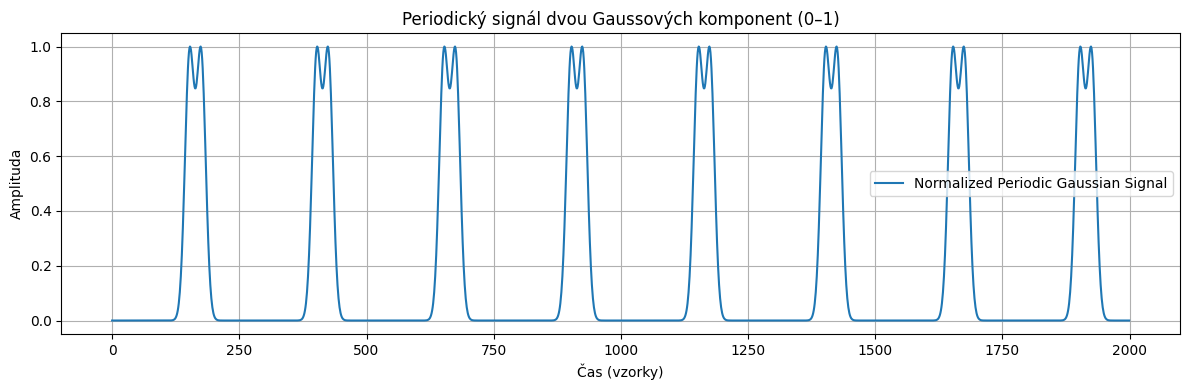

In [ ]:
import h5py
import numpy as np
import os

def save_icp_art_to_hdf5(icp: np.ndarray, art: np.ndarray, filename: str, output_dir="hdf_clean"):
    """
    Uloží ICP a ART (ABP) signály do HDF5 souboru ve struktuře:
    /waves/icp
    /waves/art

    Args:
        icp (np.ndarray): Signál ICP jako 1D pole
        art (np.ndarray): Signál ART jako 1D pole
        filename (str): Název souboru (bez přípony)
        output_dir (str): Výstupní složka pro .hdf5 soubor
    """
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, f"{filename}.hdf5")

    with h5py.File(filepath, "w") as hdf:
        wave_group = hdf.create_group("waves")
        wave_group.create_dataset("icp", data=icp.astype(np.float32))
        wave_group.create_dataset("art", data=art.astype(np.float32))

    print(f"✅ Uloženo: {filepath}")
